## Source

### http://csbdeep.bioimagecomputing.com/examples/denoising2D_probabilistic/

In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from collections import defaultdict
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


import skimage
from skimage import external
from skimage.external import tifffile
from skimage import data, img_as_float
from skimage import exposure
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.measure import compare_ssim as ssim

from tifffile import imread
from csbdeep.utils import Path, download_and_extract_zip_file, axes_dict, plot_some, plot_history
from csbdeep.io import load_training_data, save_tiff_imagej_compatible
from csbdeep.utils.tf import limit_gpu_memory
from csbdeep.models import Config, CARE

from cellvision_lib import train_test_val

Using TensorFlow backend.


In [4]:
#import training data --> update for all channels
#use GPUs

folder_path = '/gpfs/data/lionnetlab/cellvision/pilotdata/20181009-top50/'

#channel 1 --> 0
#channel 2 --> 1
#channel 3 --> 2
#channel 4 --> 3
#channel 5 --> 4

training_sets = []
testing_sets = []
val_sets = []

for i in range(1,6):
    train, test, val = train_test_val(folder_path, \
                                  channels = i, \
                                  train_pp = .67, \
                                  test_pp = .165, \
                                  val_pp = .165, \
                                  set_seed = 1)
    training_sets.append(train)
    testing_sets.append(test)
    val_sets.append(val)


In [5]:
#read in X train for each channel
X_TRAINING_SETS = []
for c in range(0,5):
    X = []
    for i in range(0,len(training_sets[c])):
        entry = skimage.external.tifffile.imread(training_sets[c][i][0])
        X.append(entry)
    X = np.array(X)
    X_TRAINING_SETS.append(X)

#read in X val for each channel
X_VALIDATION_SETS = []
for c in range(0,5):  
    X_val = []
    for i in range(0,len(val_sets[c])):
        entry = skimage.external.tifffile.imread(val_sets[c][i][0])
        X_val.append(entry)
    X_val = np.array(X_val)
    X_VALIDATION_SETS.append(X_val)

#read in X test for each channel
X_TEST_SETS = []
for c in range(0,5):
    X_test = []
    for i in range(0,len(testing_sets[c])):
        entry = skimage.external.tifffile.imread(testing_sets[c][i][0])
        X_test.append(entry)
    X_test = np.array(X_test)
    X_TEST_SETS.append(X_test)


In [6]:
#read in Y train for each channel
Y_TRAINING_SETS = []
for c in range(0,5):
    Y = []
    for i in range(0,len(training_sets[c])):
        entry = skimage.external.tifffile.imread(training_sets[c][i][1])
        Y.append(entry)
    Y = np.array(Y)
    Y_TRAINING_SETS.append(Y)

#read in Y val for each channel
Y_VALIDATION_SETS = []
for c in range(0,5):  
    Y_val = []
    for i in range(0,len(val_sets[c])):
        entry = skimage.external.tifffile.imread(val_sets[c][i][1])
        Y_val.append(entry)
    Y_val = np.array(Y_val)
    Y_VALIDATION_SETS.append(Y_val)

#read in Y test for each channel
Y_TEST_SETS = []
for c in range(0,5):
    Y_test = []
    for i in range(0,len(testing_sets[c])):
        entry = skimage.external.tifffile.imread(testing_sets[c][i][1])
        Y_test.append(entry)
    Y_test = np.array(Y_test)
    Y_TEST_SETS.append(Y_test)

In [47]:
#find new exposure scale

#create joint stack
TEMP_IMGS = []
for c in range(0,5):
    CHANNEL_IMGS = np.vstack((
        X_TRAINING_SETS[c],
        X_VALIDATION_SETS[c],
        X_TEST_SETS[c],
        Y_TRAINING_SETS[c],
        Y_VALIDATION_SETS[c],
        Y_TEST_SETS[c]))
    TEMP_IMGS.append(CHANNEL_IMGS)

ALL_IMGS = np.vstack((TEMP_IMGS[0],TEMP_IMGS[1],TEMP_IMGS[2],TEMP_IMGS[3],TEMP_IMGS[4]))

#find minimum intensity
for i in range(0,len(ALL_IMGS)):
    if i == 0:
        stack_min = ALL_IMGS[i].min()
        
    else:
        if ALL_IMGS[i].min() < stack_min:
            stack_min = ALL_IMGS[i].min()
        else: 
            stack_min = stack_min

#find maximum instensity
for i in range(0,len(ALL_IMGS)):
    if i == 0:
        stack_max = ALL_IMGS[i].max()
        
    else:
        if ALL_IMGS[i].max() > stack_max:
            stack_max = ALL_IMGS[i].max()
        else: 
            stack_max = stack_max

In [59]:
#rescale exposure intensity for all images 
#resize images --> 512 to 128 

#X train
X_TRAIN_ALL_C = []
for c in range(0,5):
    X_TRAIN = []
    for i in range(0,len(X_TRAINING_SETS[c])):
        image = exposure.rescale_intensity(X_TRAINING_SETS[c][i],in_range=(stack_min,stack_max))
        image = rescale(image, 1.0/4.0, anti_aliasing=False)
        X_TRAIN.append(image)
    X_TRAIN = np.array(X_TRAIN)
    X_TRAIN_ALL_C.append(X_TRAIN)
    
    
#X val
X_VAL_ALL_C = []
for c in range(0,5):
    X_VAL = []
    for i in range(0,len(X_VALIDATION_SETS[c])):
        image = exposure.rescale_intensity(X_VALIDATION_SETS[c][i],in_range=(stack_min,stack_max))
        image = rescale(image, 1.0/4.0, anti_aliasing=False)
        X_VAL.append(image)
    X_VAL = np.array(X_VAL)
    X_VAL_ALL_C.append(X_VAL)

#X test
X_TEST_ALL_C = []
for c in range(0,5):
    X_TEST = []
    for i in range(0,len(X_TEST_SETS[c])):
        image = exposure.rescale_intensity(X_TEST_SETS[c][i],in_range=(stack_min,stack_max))
        image = rescale(image, 1.0/4.0, anti_aliasing=False)
        X_TEST.append(image)
    X_TEST = np.array(X_TEST)
    X_TEST_ALL_C.append(X_TEST)


In [60]:
#rescale exposure intensity for all images 
#resize images --> 512 to 128 

#Y train
Y_TRAIN_ALL_C = []
for c in range(0,5):
    Y_TRAIN = []
    for i in range(0,len(Y_TRAINING_SETS[c])):
        image = exposure.rescale_intensity(Y_TRAINING_SETS[c][i],in_range=(stack_min,stack_max))
        image = rescale(image, 1.0/4.0, anti_aliasing=False)
        Y_TRAIN.append(image)
    Y_TRAIN = np.array(Y_TRAIN)
    Y_TRAIN_ALL_C.append(Y_TRAIN)
    
    
#Y val
Y_VAL_ALL_C = []
for c in range(0,5):
    Y_VAL = []
    for i in range(0,len(Y_VALIDATION_SETS[c])):
        image = exposure.rescale_intensity(Y_VALIDATION_SETS[c][i],in_range=(stack_min,stack_max))
        image = rescale(image, 1.0/4.0, anti_aliasing=False)
        Y_VAL.append(image)
    Y_VAL = np.array(Y_VAL)
    Y_VAL_ALL_C.append(Y_VAL)

#Y test
Y_TEST_ALL_C = []
for c in range(0,5):
    Y_TEST = []
    for i in range(0,len(Y_TEST_SETS[c])):
        image = exposure.rescale_intensity(Y_TEST_SETS[c][i],in_range=(stack_min,stack_max))
        image = rescale(image, 1.0/4.0, anti_aliasing=False)
        Y_TEST.append(image)
    Y_TEST = np.array(Y_TEST)
    Y_TEST_ALL_C.append(Y_TEST)



In [65]:
print(X_TRAIN_ALL_C[0].shape)
print(X_VAL_ALL_C[0].shape)
print(X_TEST_ALL_C[0].shape)
print(Y_TRAIN_ALL_C[0].shape)
print(Y_VAL_ALL_C[0].shape)
print(Y_TEST_ALL_C[0].shape)

(4339, 128, 128, 1)
(1068, 128, 128, 1)
(1069, 128, 128, 1)
(4339, 128, 128, 1)
(1068, 128, 128, 1)
(1069, 128, 128, 1)


In [64]:
#reshape X and Y --> (3886, 128, 128) to (3886, 128, 128, 1)

for c in range(0,5):
    X_TRAIN_ALL_C[c] = X_TRAIN_ALL_C[c].reshape(len(X_TRAIN_ALL_C[c]),128,128,1)
    X_VAL_ALL_C[c] = X_VAL_ALL_C[c].reshape(len(X_VAL_ALL_C[c]), 128, 128,1)
    X_TEST_ALL_C[c] = X_TEST_ALL_C[c].reshape(len(X_TEST_ALL_C[c]), 128, 128,1)
    Y_TRAIN_ALL_C[c] = Y_TRAIN_ALL_C[c].reshape(len(Y_TRAIN_ALL_C[c]), 128, 128,1)
    Y_VAL_ALL_C[c] = Y_VAL_ALL_C[c].reshape(len(Y_VAL_ALL_C[c]), 128, 128,1)
    Y_TEST_ALL_C[c] = Y_TEST_ALL_C[c].reshape(len(Y_TEST_ALL_C[c]), 128, 128,1)


In [66]:
#Image Axes
#X: columns, Y: rows, Z: planes, C: channels, T: frames/time, (S: samples/images)
axes = 'SYXC'
c = axes_dict(axes)['C']

n_channel_in_1,n_channel_out_1 = X_TRAIN_ALL_C[0].shape[c], Y_TRAIN_ALL_C[0].shape[c]
n_channel_in_2,n_channel_out_2 = X_TRAIN_ALL_C[1].shape[c], Y_TRAIN_ALL_C[1].shape[c]
n_channel_in_3,n_channel_out_3 = X_TRAIN_ALL_C[2].shape[c], Y_TRAIN_ALL_C[2].shape[c]
n_channel_in_4,n_channel_out_4 = X_TRAIN_ALL_C[3].shape[c], Y_TRAIN_ALL_C[3].shape[c]
n_channel_in_5,n_channel_out_5 = X_TRAIN_ALL_C[4].shape[c], Y_TRAIN_ALL_C[4].shape[c]

In [67]:
#set config files
config_1 = Config(axes, n_channel_in_1, n_channel_out_1, probabilistic=True, train_steps_per_epoch=30)
config_2 = Config(axes, n_channel_in_2, n_channel_out_2, probabilistic=True, train_steps_per_epoch=30)
config_3 = Config(axes, n_channel_in_3, n_channel_out_3, probabilistic=True, train_steps_per_epoch=30)
config_4 = Config(axes, n_channel_in_4, n_channel_out_4, probabilistic=True, train_steps_per_epoch=30)
config_5 = Config(axes, n_channel_in_5, n_channel_out_5, probabilistic=True, train_steps_per_epoch=30)


print(config_1)
vars(config_1)

Config(axes='YXC', n_channel_in=1, n_channel_out=1, n_dim=2, probabilistic=True, train_batch_size=16, train_checkpoint='weights_best.h5', train_epochs=100, train_learning_rate=0.0004, train_loss='laplace', train_reduce_lr={'factor': 0.5, 'patience': 10}, train_steps_per_epoch=30, train_tensorboard=True, unet_input_shape=(None, None, 1), unet_kern_size=5, unet_last_activation='linear', unet_n_depth=2, unet_n_first=32, unet_residual=True)


{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'probabilistic': True,
 'unet_residual': True,
 'unet_n_depth': 2,
 'unet_kern_size': 5,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 1),
 'train_loss': 'laplace',
 'train_epochs': 100,
 'train_steps_per_epoch': 30,
 'train_learning_rate': 0.0004,
 'train_batch_size': 16,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10}}

In [68]:
#config model
hn_model_1 = CARE(config_1, 'hn_model_1', basedir='models')
hn_model_2 = CARE(config_2, 'hn_model_2', basedir='models')
hn_model_3 = CARE(config_3, 'hn_model_3', basedir='models')
hn_model_4 = CARE(config_4, 'hn_model_4', basedir='models')
hn_model_5 = CARE(config_5, 'hn_model_5', basedir='models')



In [72]:
#history channel 1
hn_history_1 = hn_model_1.train(X_TRAIN_ALL_C[0],Y_TRAIN_ALL_C[0], \
                                validation_data=(X_VAL_ALL_C[0],Y_VAL_ALL_C[0]))

Epoch 1/100
30/30 [==============================] - 5s 156ms/step - loss: 0.7495 - mse: 0.0041 - mae: 0.0436 - val_loss: 0.2848 - val_mse: 0.0015 - val_mae: 0.0247
Epoch 2/100
30/30 [==============================] - 2s 54ms/step - loss: -0.1458 - mse: 0.0053 - mae: 0.0570 - val_loss: -1.7595 - val_mse: 0.0013 - val_mae: 0.0262
Epoch 3/100
30/30 [==============================] - 2s 60ms/step - loss: -1.6389 - mse: 0.0015 - mae: 0.0271 - val_loss: -1.7901 - val_mse: 0.0012 - val_mae: 0.0245
Epoch 4/100
30/30 [==============================] - 2s 54ms/step - loss: -1.8735 - mse: 0.0014 - mae: 0.0257 - val_loss: -1.9782 - val_mse: 0.0013 - val_mae: 0.0251
Epoch 5/100
30/30 [==============================] - 2s 54ms/step - loss: -1.8721 - mse: 0.0014 - mae: 0.0261 - val_loss: -1.7504 - val_mse: 0.0013 - val_mae: 0.0247
Epoch 6/100
30/30 [==============================] - 2s 54ms/step - loss: -1.6520 - mse: 0.0015 - mae: 0.0300 - val_loss: -1.2319 - val_mse: 0.0011 - val_mae: 0.0302
Epoch

Epoch 48/100
30/30 [==============================] - 2s 54ms/step - loss: -3.3918 - mse: 9.0292e-05 - mae: 0.0065 - val_loss: -3.6057 - val_mse: 7.5583e-05 - val_mae: 0.0056
Epoch 49/100
30/30 [==============================] - 2s 54ms/step - loss: -3.3974 - mse: 8.1882e-05 - mae: 0.0064 - val_loss: -3.6159 - val_mse: 7.1682e-05 - val_mae: 0.0056
Epoch 50/100
30/30 [==============================] - 2s 55ms/step - loss: -3.3281 - mse: 9.6197e-05 - mae: 0.0070 - val_loss: -2.8545 - val_mse: 1.3522e-04 - val_mae: 0.0099
Epoch 51/100
30/30 [==============================] - 2s 54ms/step - loss: -3.3720 - mse: 8.9485e-05 - mae: 0.0066 - val_loss: -3.3445 - val_mse: 8.9789e-05 - val_mae: 0.0067
Epoch 52/100
30/30 [==============================] - 2s 55ms/step - loss: -3.6000 - mse: 6.5905e-05 - mae: 0.0055 - val_loss: -3.3819 - val_mse: 8.3876e-05 - val_mae: 0.0064
Epoch 53/100
30/30 [==============================] - 2s 54ms/step - loss: -3.2318 - mse: 9.3184e-05 - mae: 0.0070 - val_loss

Epoch 94/100
30/30 [==============================] - 2s 54ms/step - loss: -3.9025 - mse: 5.3237e-05 - mae: 0.0045 - val_loss: -3.9209 - val_mse: 5.2434e-05 - val_mae: 0.0045
Epoch 95/100
30/30 [==============================] - 2s 54ms/step - loss: -3.8913 - mse: 5.5961e-05 - mae: 0.0046 - val_loss: -3.7588 - val_mse: 5.7395e-05 - val_mae: 0.0049
Epoch 96/100
30/30 [==============================] - 2s 55ms/step - loss: -3.9021 - mse: 5.1193e-05 - mae: 0.0045 - val_loss: -3.8700 - val_mse: 5.2415e-05 - val_mae: 0.0046
Epoch 97/100
30/30 [==============================] - 2s 55ms/step - loss: -3.8849 - mse: 5.2991e-05 - mae: 0.0046 - val_loss: -3.9346 - val_mse: 5.2331e-05 - val_mae: 0.0045
Epoch 98/100
30/30 [==============================] - 2s 54ms/step - loss: -3.9307 - mse: 4.9826e-05 - mae: 0.0044 - val_loss: -3.9348 - val_mse: 5.1776e-05 - val_mae: 0.0045
Epoch 99/100
30/30 [==============================] - 2s 55ms/step - loss: -3.8145 - mse: 5.8468e-05 - mae: 0.0048 - val_loss

In [73]:
#history channel 2
hn_history_2 = hn_model_2.train(X_TRAIN_ALL_C[1],Y_TRAIN_ALL_C[1], \
                                validation_data=(X_VAL_ALL_C[1],Y_VAL_ALL_C[1]))

Epoch 1/100
30/30 [==============================] - 3s 90ms/step - loss: 0.0169 - mse: 0.0038 - mae: 0.0471 - val_loss: -0.0074 - val_mse: 0.0016 - val_mae: 0.0348
Epoch 2/100
30/30 [==============================] - 2s 55ms/step - loss: -1.3950 - mse: 0.0014 - mae: 0.0287 - val_loss: -1.8564 - val_mse: 0.0013 - val_mae: 0.0233
Epoch 3/100
30/30 [==============================] - 2s 54ms/step - loss: -1.7918 - mse: 0.0012 - mae: 0.0242 - val_loss: -1.2105 - val_mse: 0.0028 - val_mae: 0.0479
Epoch 4/100
30/30 [==============================] - 2s 55ms/step - loss: -1.0263 - mse: 0.0016 - mae: 0.0319 - val_loss: -1.2152 - val_mse: 0.0020 - val_mae: 0.0410
Epoch 5/100
30/30 [==============================] - 2s 55ms/step - loss: -1.8918 - mse: 9.1998e-04 - mae: 0.0217 - val_loss: -2.1279 - val_mse: 7.3848e-04 - val_mae: 0.0185
Epoch 6/100
30/30 [==============================] - 2s 56ms/step - loss: -1.9574 - mse: 7.6263e-04 - mae: 0.0199 - val_loss: -0.7640 - val_mse: 0.0025 - val_mae: 


Epoch 00047: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.
Epoch 48/100
30/30 [==============================] - 2s 55ms/step - loss: -3.2581 - mse: 7.7352e-05 - mae: 0.0059 - val_loss: -3.4627 - val_mse: 7.8426e-05 - val_mae: 0.0057
Epoch 49/100
30/30 [==============================] - 2s 55ms/step - loss: -3.5774 - mse: 7.5303e-05 - mae: 0.0055 - val_loss: -3.7518 - val_mse: 6.3587e-05 - val_mae: 0.0050
Epoch 50/100
30/30 [==============================] - 2s 55ms/step - loss: -3.5117 - mse: 7.0096e-05 - mae: 0.0057 - val_loss: -3.7351 - val_mse: 6.6869e-05 - val_mae: 0.0049
Epoch 51/100
30/30 [==============================] - 2s 55ms/step - loss: -3.5857 - mse: 6.9235e-05 - mae: 0.0055 - val_loss: -3.1442 - val_mse: 8.2538e-05 - val_mae: 0.0074
Epoch 52/100
30/30 [==============================] - 2s 55ms/step - loss: -3.5658 - mse: 6.7674e-05 - mae: 0.0055 - val_loss: -3.4373 - val_mse: 6.3822e-05 - val_mae: 0.0059
Epoch 53/100
30/30 [========================

Epoch 94/100
30/30 [==============================] - 2s 55ms/step - loss: -4.0685 - mse: 3.2930e-05 - mae: 0.0036 - val_loss: -4.1549 - val_mse: 3.1096e-05 - val_mae: 0.0034
Epoch 95/100
30/30 [==============================] - 2s 55ms/step - loss: -4.1063 - mse: 3.1269e-05 - mae: 0.0035 - val_loss: -4.1895 - val_mse: 3.1918e-05 - val_mae: 0.0034
Epoch 96/100
30/30 [==============================] - 2s 55ms/step - loss: -4.0515 - mse: 3.2213e-05 - mae: 0.0036 - val_loss: -4.0951 - val_mse: 3.0802e-05 - val_mae: 0.0036
Epoch 97/100
30/30 [==============================] - 2s 55ms/step - loss: -4.1166 - mse: 3.0490e-05 - mae: 0.0035 - val_loss: -4.1916 - val_mse: 3.2746e-05 - val_mae: 0.0034
Epoch 98/100
30/30 [==============================] - 2s 55ms/step - loss: -4.1282 - mse: 3.3267e-05 - mae: 0.0035 - val_loss: -3.8616 - val_mse: 3.3568e-05 - val_mae: 0.0040
Epoch 99/100
30/30 [==============================] - 2s 55ms/step - loss: -4.0201 - mse: 3.4471e-05 - mae: 0.0038 - val_loss

In [74]:
#history channel 3
hn_history_3 = hn_model_3.train(X_TRAIN_ALL_C[2],Y_TRAIN_ALL_C[2], \
                                validation_data=(X_VAL_ALL_C[2],Y_VAL_ALL_C[2]))

Epoch 1/100
30/30 [==============================] - 3s 94ms/step - loss: 0.3777 - mse: 0.0033 - mae: 0.0385 - val_loss: -0.2938 - val_mse: 0.0012 - val_mae: 0.0322
Epoch 2/100
30/30 [==============================] - 2s 54ms/step - loss: 0.0901 - mse: 0.0027 - mae: 0.0418 - val_loss: 0.2533 - val_mse: 0.0014 - val_mae: 0.0346
Epoch 3/100
30/30 [==============================] - 2s 55ms/step - loss: -0.8724 - mse: 0.0038 - mae: 0.0494 - val_loss: -1.3533 - val_mse: 0.0017 - val_mae: 0.0379
Epoch 4/100
30/30 [==============================] - 2s 55ms/step - loss: -0.9827 - mse: 0.0013 - mae: 0.0299 - val_loss: -0.5916 - val_mse: 0.0017 - val_mae: 0.0369
Epoch 5/100
30/30 [==============================] - 2s 55ms/step - loss: -1.4385 - mse: 0.0011 - mae: 0.0262 - val_loss: -1.2363 - val_mse: 9.7363e-04 - val_mae: 0.0282
Epoch 6/100
30/30 [==============================] - 2s 55ms/step - loss: -1.4239 - mse: 0.0012 - mae: 0.0279 - val_loss: 0.8848 - val_mse: 0.0039 - val_mae: 0.0586
Epoc

30/30 [==============================] - 2s 54ms/step - loss: -3.0900 - mse: 9.5108e-05 - mae: 0.0078 - val_loss: -2.6389 - val_mse: 1.8014e-04 - val_mae: 0.0120
Epoch 49/100
30/30 [==============================] - 2s 54ms/step - loss: -3.1738 - mse: 7.7733e-05 - mae: 0.0071 - val_loss: -3.3862 - val_mse: 5.9671e-05 - val_mae: 0.0059
Epoch 50/100
30/30 [==============================] - 2s 54ms/step - loss: -3.2272 - mse: 7.1827e-05 - mae: 0.0069 - val_loss: -3.2033 - val_mse: 6.7623e-05 - val_mae: 0.0072
Epoch 51/100
30/30 [==============================] - 2s 54ms/step - loss: -3.4074 - mse: 5.4874e-05 - mae: 0.0059 - val_loss: -3.5170 - val_mse: 4.5374e-05 - val_mae: 0.0054
Epoch 52/100
30/30 [==============================] - 2s 54ms/step - loss: -3.2022 - mse: 6.9493e-05 - mae: 0.0066 - val_loss: -3.2560 - val_mse: 6.5485e-05 - val_mae: 0.0065
Epoch 53/100
30/30 [==============================] - 2s 54ms/step - loss: -3.1887 - mse: 7.1278e-05 - mae: 0.0069 - val_loss: -3.7679 - v

30/30 [==============================] - 2s 54ms/step - loss: -4.2327 - mse: 1.6217e-05 - mae: 0.0028 - val_loss: -4.0095 - val_mse: 2.1777e-05 - val_mae: 0.0034
Epoch 95/100
30/30 [==============================] - 2s 53ms/step - loss: -4.2780 - mse: 1.6336e-05 - mae: 0.0028 - val_loss: -4.4609 - val_mse: 1.3902e-05 - val_mae: 0.0024
Epoch 96/100
30/30 [==============================] - 2s 54ms/step - loss: -3.9549 - mse: 2.1172e-05 - mae: 0.0035 - val_loss: -4.1198 - val_mse: 1.8639e-05 - val_mae: 0.0030
Epoch 97/100
30/30 [==============================] - 2s 54ms/step - loss: -4.2684 - mse: 1.5214e-05 - mae: 0.0027 - val_loss: -3.6402 - val_mse: 2.8319e-05 - val_mae: 0.0044
Epoch 98/100
30/30 [==============================] - 2s 54ms/step - loss: -4.1001 - mse: 1.8654e-05 - mae: 0.0032 - val_loss: -4.2012 - val_mse: 1.5382e-05 - val_mae: 0.0028
Epoch 99/100
30/30 [==============================] - 2s 54ms/step - loss: -4.1312 - mse: 1.7576e-05 - mae: 0.0030 - val_loss: -3.8091 - v

In [75]:
#history channel 4
hn_history_4 = hn_model_4.train(X_TRAIN_ALL_C[3],Y_TRAIN_ALL_C[3], \
                                validation_data=(X_VAL_ALL_C[3],Y_VAL_ALL_C[3]))

Epoch 1/100
30/30 [==============================] - 3s 94ms/step - loss: 0.1039 - mse: 0.0032 - mae: 0.0389 - val_loss: 0.1353 - val_mse: 0.0027 - val_mae: 0.0505
Epoch 2/100
30/30 [==============================] - 2s 54ms/step - loss: -0.2090 - mse: 0.0028 - mae: 0.0380 - val_loss: -0.4893 - val_mse: 6.4026e-04 - val_mae: 0.0235
Epoch 3/100
30/30 [==============================] - 2s 55ms/step - loss: -0.8030 - mse: 0.0019 - mae: 0.0352 - val_loss: -1.3578 - val_mse: 7.0197e-04 - val_mae: 0.0235
Epoch 4/100
30/30 [==============================] - 2s 55ms/step - loss: -0.8170 - mse: 0.0014 - mae: 0.0284 - val_loss: -1.1522 - val_mse: 1.4938e-04 - val_mae: 0.0100
Epoch 5/100
30/30 [==============================] - 2s 55ms/step - loss: -1.2995 - mse: 0.0011 - mae: 0.0283 - val_loss: -0.9070 - val_mse: 0.0020 - val_mae: 0.0439
Epoch 6/100
30/30 [==============================] - 2s 55ms/step - loss: -1.4556 - mse: 9.1631e-04 - mae: 0.0260 - val_loss: 1.2447 - val_mse: 0.0049 - val_mae

30/30 [==============================] - 2s 55ms/step - loss: -3.0306 - mse: 7.9363e-05 - mae: 0.0081 - val_loss: -3.1218 - val_mse: 6.3893e-05 - val_mae: 0.0072
Epoch 49/100
30/30 [==============================] - 2s 55ms/step - loss: -3.0565 - mse: 7.6164e-05 - mae: 0.0079 - val_loss: -3.0986 - val_mse: 6.9718e-05 - val_mae: 0.0076
Epoch 50/100
30/30 [==============================] - 2s 54ms/step - loss: -3.0751 - mse: 7.4551e-05 - mae: 0.0078 - val_loss: -3.1700 - val_mse: 5.8286e-05 - val_mae: 0.0069
Epoch 51/100
30/30 [==============================] - 2s 54ms/step - loss: -3.0972 - mse: 7.2924e-05 - mae: 0.0076 - val_loss: -3.0357 - val_mse: 7.9072e-05 - val_mae: 0.0082
Epoch 52/100
30/30 [==============================] - 2s 55ms/step - loss: -3.1077 - mse: 6.9248e-05 - mae: 0.0076 - val_loss: -2.9721 - val_mse: 9.0234e-05 - val_mae: 0.0089
Epoch 53/100
30/30 [==============================] - 2s 54ms/step - loss: -3.1377 - mse: 6.8138e-05 - mae: 0.0073 - val_loss: -3.4438 - v

Epoch 94/100
30/30 [==============================] - 2s 54ms/step - loss: -4.1389 - mse: 1.4714e-05 - mae: 0.0029 - val_loss: -4.2483 - val_mse: 1.2018e-05 - val_mae: 0.0026
Epoch 95/100
30/30 [==============================] - 2s 54ms/step - loss: -4.1509 - mse: 1.4167e-05 - mae: 0.0029 - val_loss: -4.3434 - val_mse: 1.0979e-05 - val_mae: 0.0023
Epoch 96/100
30/30 [==============================] - 2s 54ms/step - loss: -4.3785 - mse: 1.0705e-05 - mae: 0.0023 - val_loss: -4.0252 - val_mse: 1.5242e-05 - val_mae: 0.0032
Epoch 97/100
30/30 [==============================] - 2s 54ms/step - loss: -4.1907 - mse: 1.4025e-05 - mae: 0.0028 - val_loss: -3.5919 - val_mse: 2.6586e-05 - val_mae: 0.0044
Epoch 98/100
30/30 [==============================] - 2s 54ms/step - loss: -4.1771 - mse: 1.4097e-05 - mae: 0.0028 - val_loss: -4.4512 - val_mse: 9.4471e-06 - val_mae: 0.0021
Epoch 99/100
30/30 [==============================] - 2s 55ms/step - loss: -4.4093 - mse: 1.0247e-05 - mae: 0.0023 - val_loss

In [76]:
#history channel 5
hn_history_5 = hn_model_5.train(X_TRAIN_ALL_C[4],Y_TRAIN_ALL_C[4], \
                                validation_data=(X_VAL_ALL_C[4],Y_VAL_ALL_C[4]))

Epoch 1/100
30/30 [==============================] - 3s 99ms/step - loss: 0.3231 - mse: 0.0039 - mae: 0.0364 - val_loss: 0.2370 - val_mse: 6.3416e-05 - val_mae: 0.0070
Epoch 2/100
30/30 [==============================] - 2s 55ms/step - loss: 0.2572 - mse: 0.0135 - mae: 0.0852 - val_loss: 0.3225 - val_mse: 0.0080 - val_mae: 0.0879
Epoch 3/100
30/30 [==============================] - 2s 55ms/step - loss: 0.1738 - mse: 0.0016 - mae: 0.0235 - val_loss: -0.2006 - val_mse: 0.0115 - val_mae: 0.1018
Epoch 4/100
30/30 [==============================] - 2s 55ms/step - loss: -0.0361 - mse: 0.0054 - mae: 0.0511 - val_loss: 0.1463 - val_mse: 0.0028 - val_mae: 0.0508
Epoch 5/100
30/30 [==============================] - 2s 56ms/step - loss: -0.2506 - mse: 0.0030 - mae: 0.0464 - val_loss: -0.6388 - val_mse: 0.0010 - val_mae: 0.0308
Epoch 6/100
30/30 [==============================] - 2s 55ms/step - loss: -0.6944 - mse: 0.0024 - mae: 0.0354 - val_loss: 0.9067 - val_mse: 0.0131 - val_mae: 0.1103
Epoch 7

30/30 [==============================] - 2s 54ms/step - loss: -2.9161 - mse: 1.0158e-04 - mae: 0.0090 - val_loss: -2.8298 - val_mse: 1.1466e-04 - val_mae: 0.0102
Epoch 49/100
30/30 [==============================] - 2s 54ms/step - loss: -2.9631 - mse: 9.3830e-05 - mae: 0.0086 - val_loss: -2.9851 - val_mse: 8.3402e-05 - val_mae: 0.0085
Epoch 50/100
30/30 [==============================] - 2s 54ms/step - loss: -2.9503 - mse: 9.5117e-05 - mae: 0.0088 - val_loss: -2.8305 - val_mse: 1.0728e-04 - val_mae: 0.0099
Epoch 51/100
30/30 [==============================] - 2s 54ms/step - loss: -2.9942 - mse: 8.8726e-05 - mae: 0.0084 - val_loss: -3.0410 - val_mse: 6.9435e-05 - val_mae: 0.0078
Epoch 52/100
30/30 [==============================] - 2s 55ms/step - loss: -3.1092 - mse: 7.2257e-05 - mae: 0.0074 - val_loss: -3.0634 - val_mse: 7.0547e-05 - val_mae: 0.0079
Epoch 53/100
30/30 [==============================] - 2s 54ms/step - loss: -3.1843 - mse: 6.6340e-05 - mae: 0.0068 - val_loss: -3.1959 - v

30/30 [==============================] - 2s 55ms/step - loss: -4.5306 - mse: 7.4493e-06 - mae: 0.0020 - val_loss: -4.3223 - val_mse: 9.1074e-06 - val_mae: 0.0024
Epoch 95/100
30/30 [==============================] - 2s 55ms/step - loss: -4.2960 - mse: 1.0262e-05 - mae: 0.0024 - val_loss: -4.5171 - val_mse: 7.3417e-06 - val_mae: 0.0020
Epoch 96/100
30/30 [==============================] - 2s 55ms/step - loss: -4.3822 - mse: 9.6387e-06 - mae: 0.0023 - val_loss: -3.9224 - val_mse: 1.6503e-05 - val_mae: 0.0034
Epoch 97/100
30/30 [==============================] - 2s 55ms/step - loss: -4.3075 - mse: 9.6382e-06 - mae: 0.0024 - val_loss: -4.4339 - val_mse: 8.0829e-06 - val_mae: 0.0021
Epoch 98/100
30/30 [==============================] - 2s 55ms/step - loss: -4.5562 - mse: 7.0218e-06 - mae: 0.0019 - val_loss: -4.4187 - val_mse: 9.1419e-06 - val_mae: 0.0022
Epoch 99/100
30/30 [==============================] - 2s 55ms/step - loss: -4.3650 - mse: 9.3980e-06 - mae: 0.0023 - val_loss: -4.5660 - v

['loss', 'lr', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse']


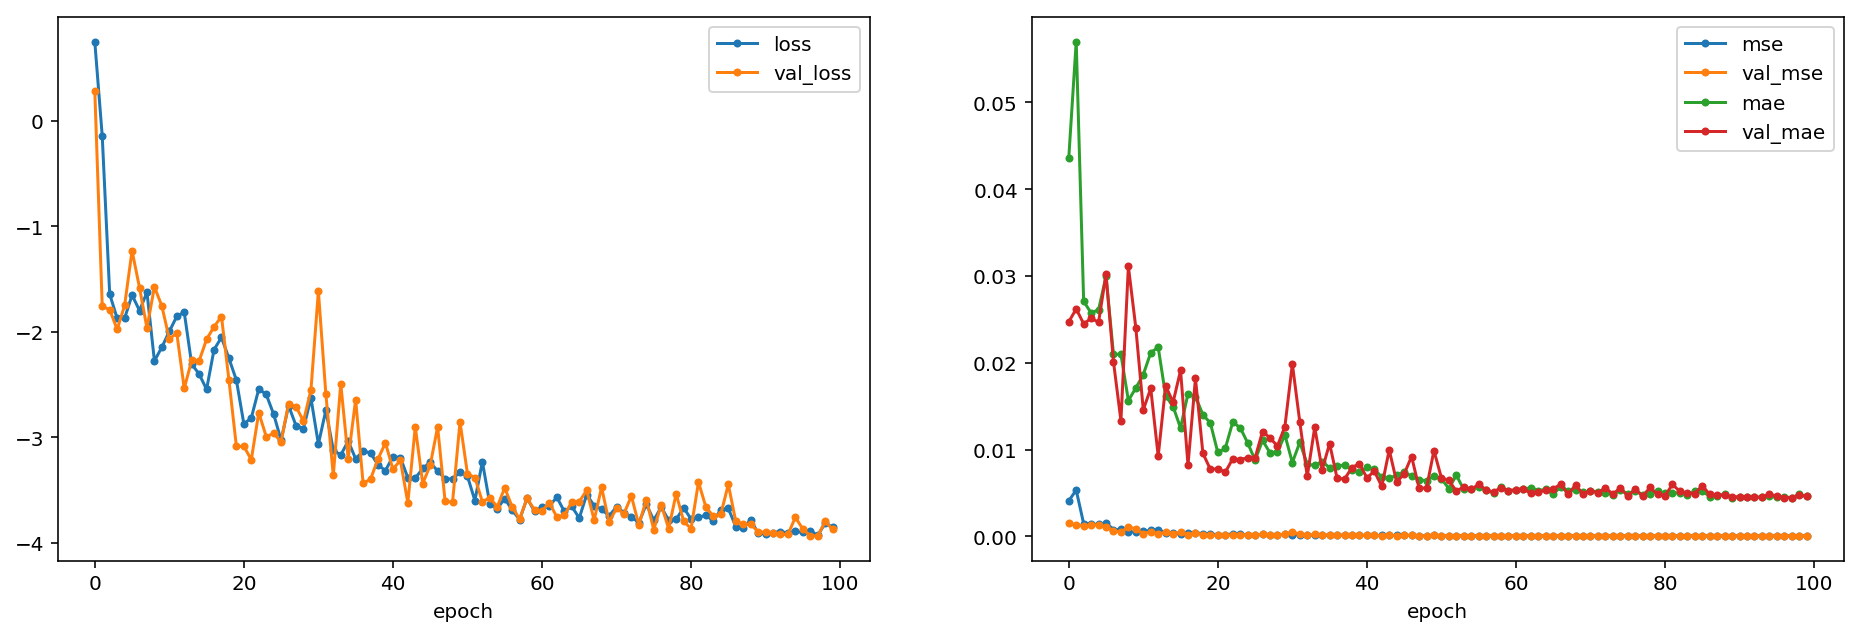

In [78]:
print(sorted(list(hn_history_1.history.keys())))
plt.figure(figsize=(16,5))
plot_history(hn_history_1,['loss','val_loss'],['mse','val_mse','mae','val_mae']);

['loss', 'lr', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse']


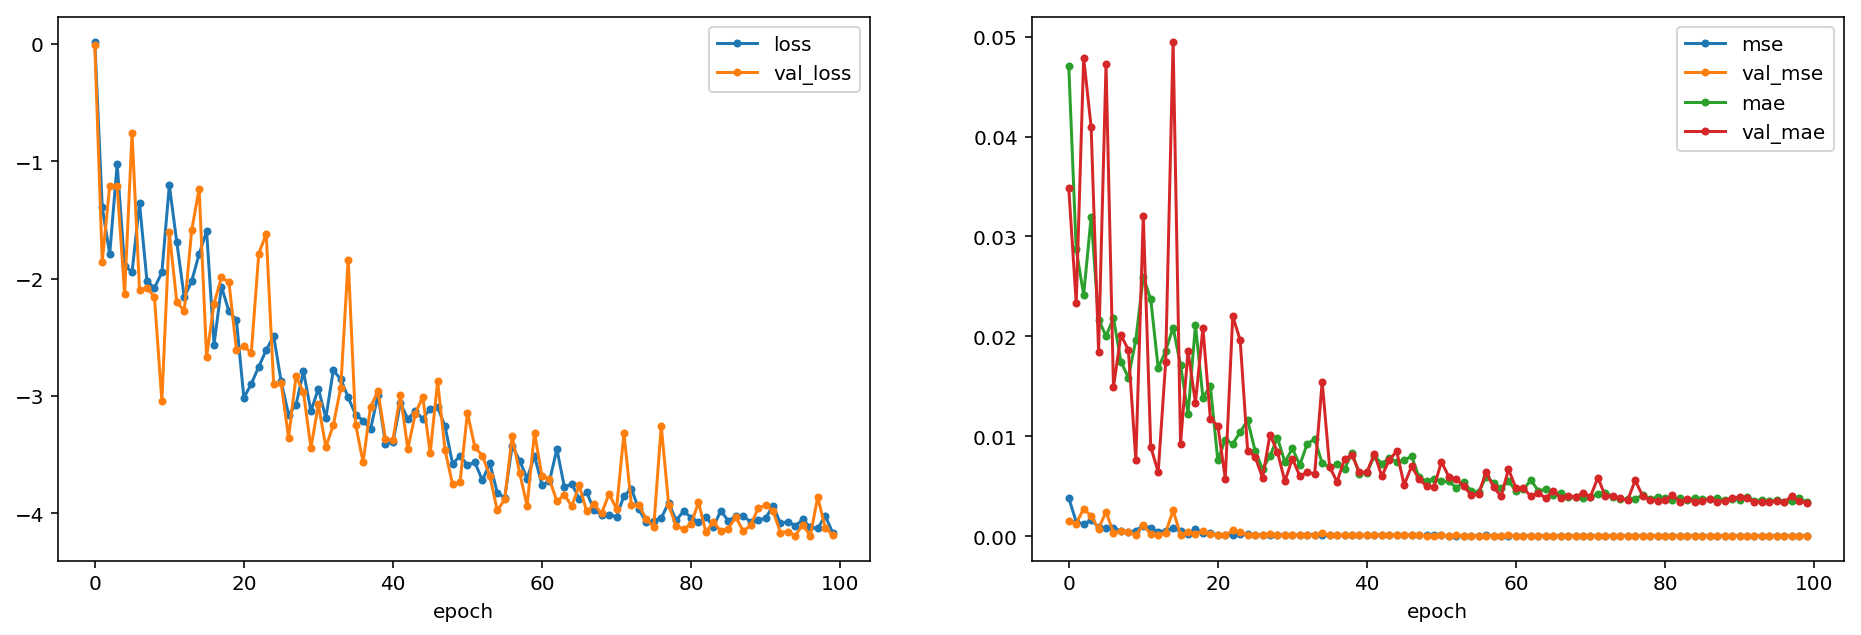

In [79]:
print(sorted(list(hn_history_2.history.keys())))
plt.figure(figsize=(16,5))
plot_history(hn_history_2,['loss','val_loss'],['mse','val_mse','mae','val_mae']);

['loss', 'lr', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse']


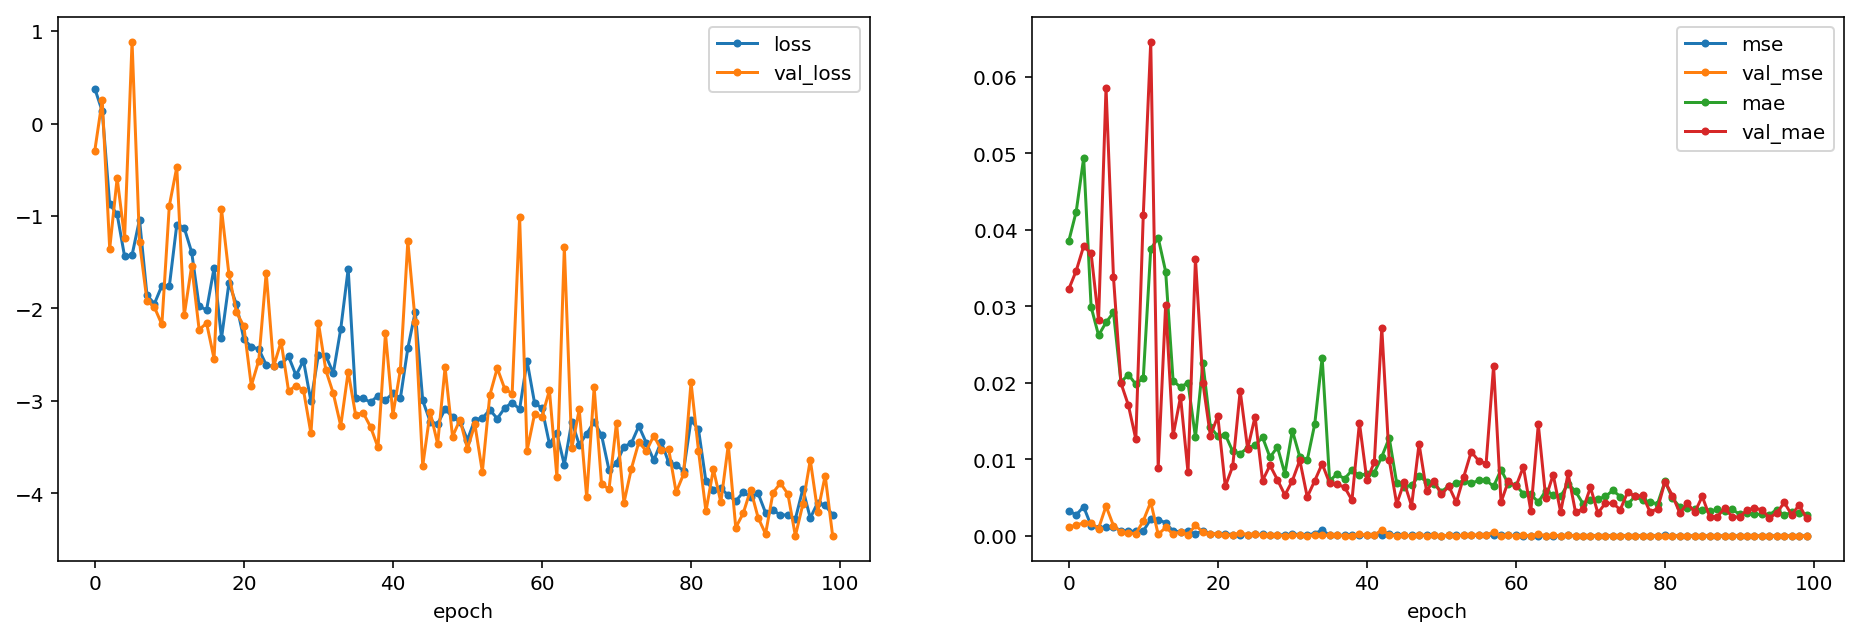

In [80]:
print(sorted(list(hn_history_3.history.keys())))
plt.figure(figsize=(16,5))
plot_history(hn_history_3,['loss','val_loss'],['mse','val_mse','mae','val_mae']);

['loss', 'lr', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse']


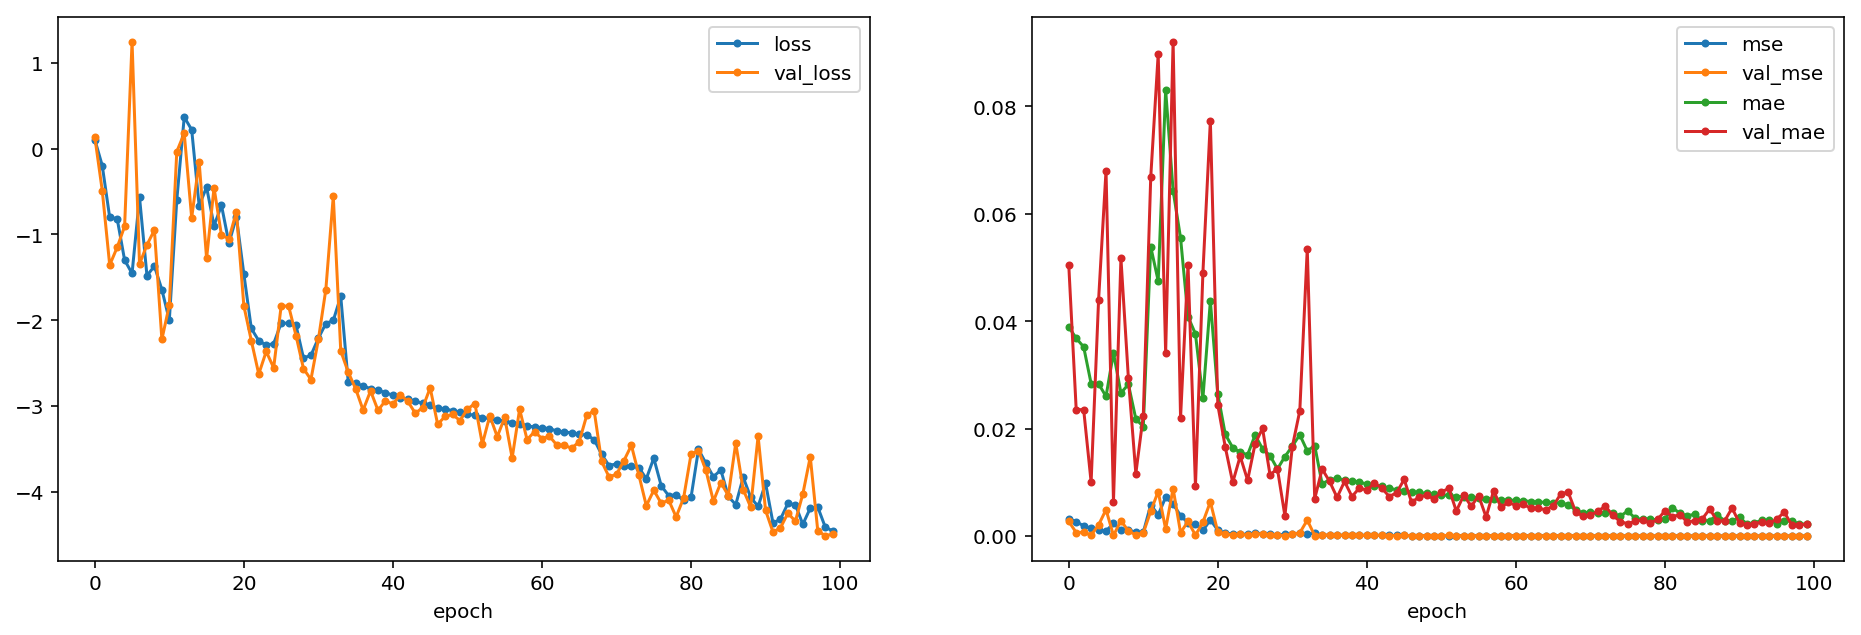

In [81]:
print(sorted(list(hn_history_4.history.keys())))
plt.figure(figsize=(16,5))
plot_history(hn_history_4,['loss','val_loss'],['mse','val_mse','mae','val_mae']);

['loss', 'lr', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse']


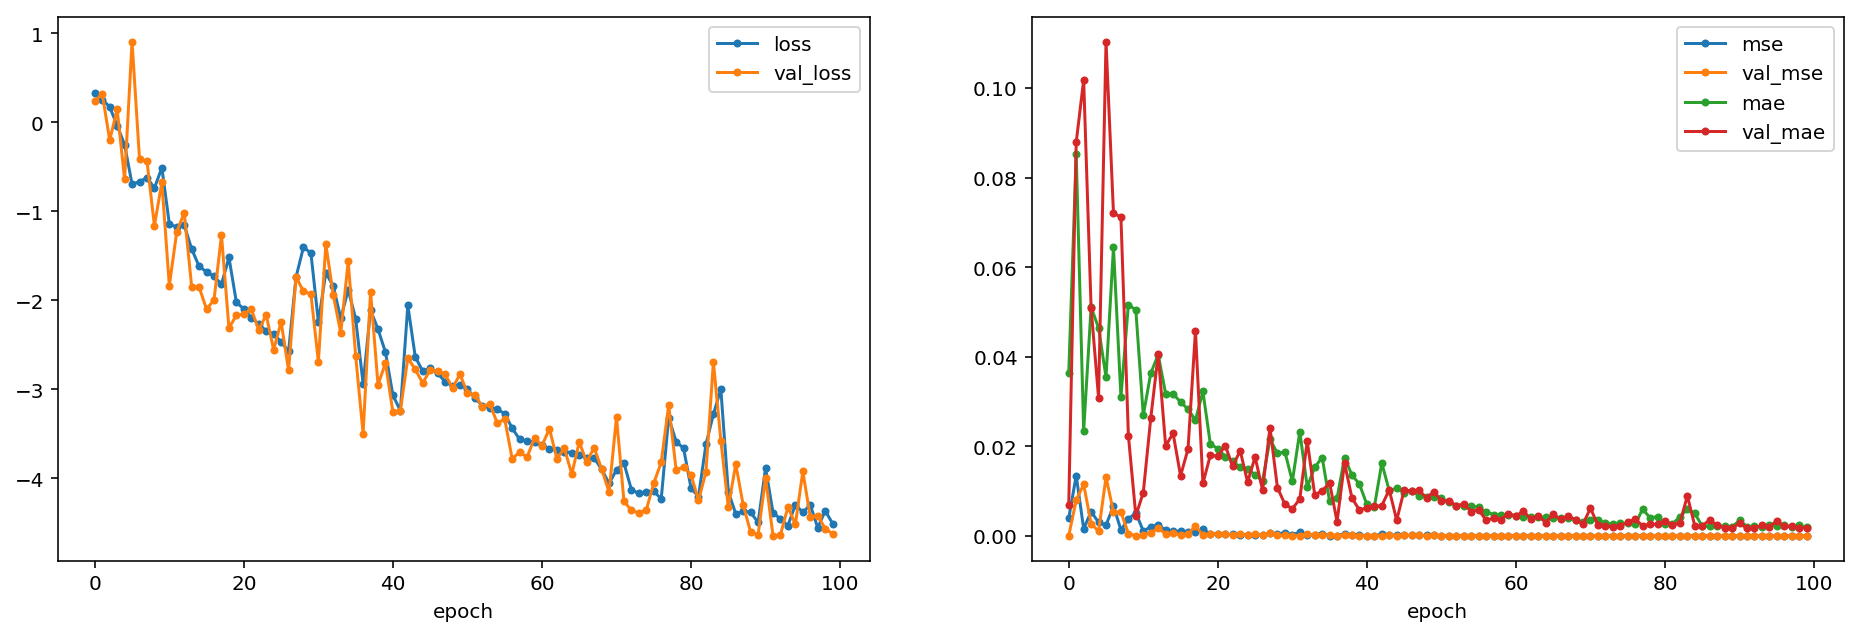

In [82]:
print(sorted(list(hn_history_5.history.keys())))
plt.figure(figsize=(16,5))
plot_history(hn_history_5,['loss','val_loss'],['mse','val_mse','mae','val_mae']);

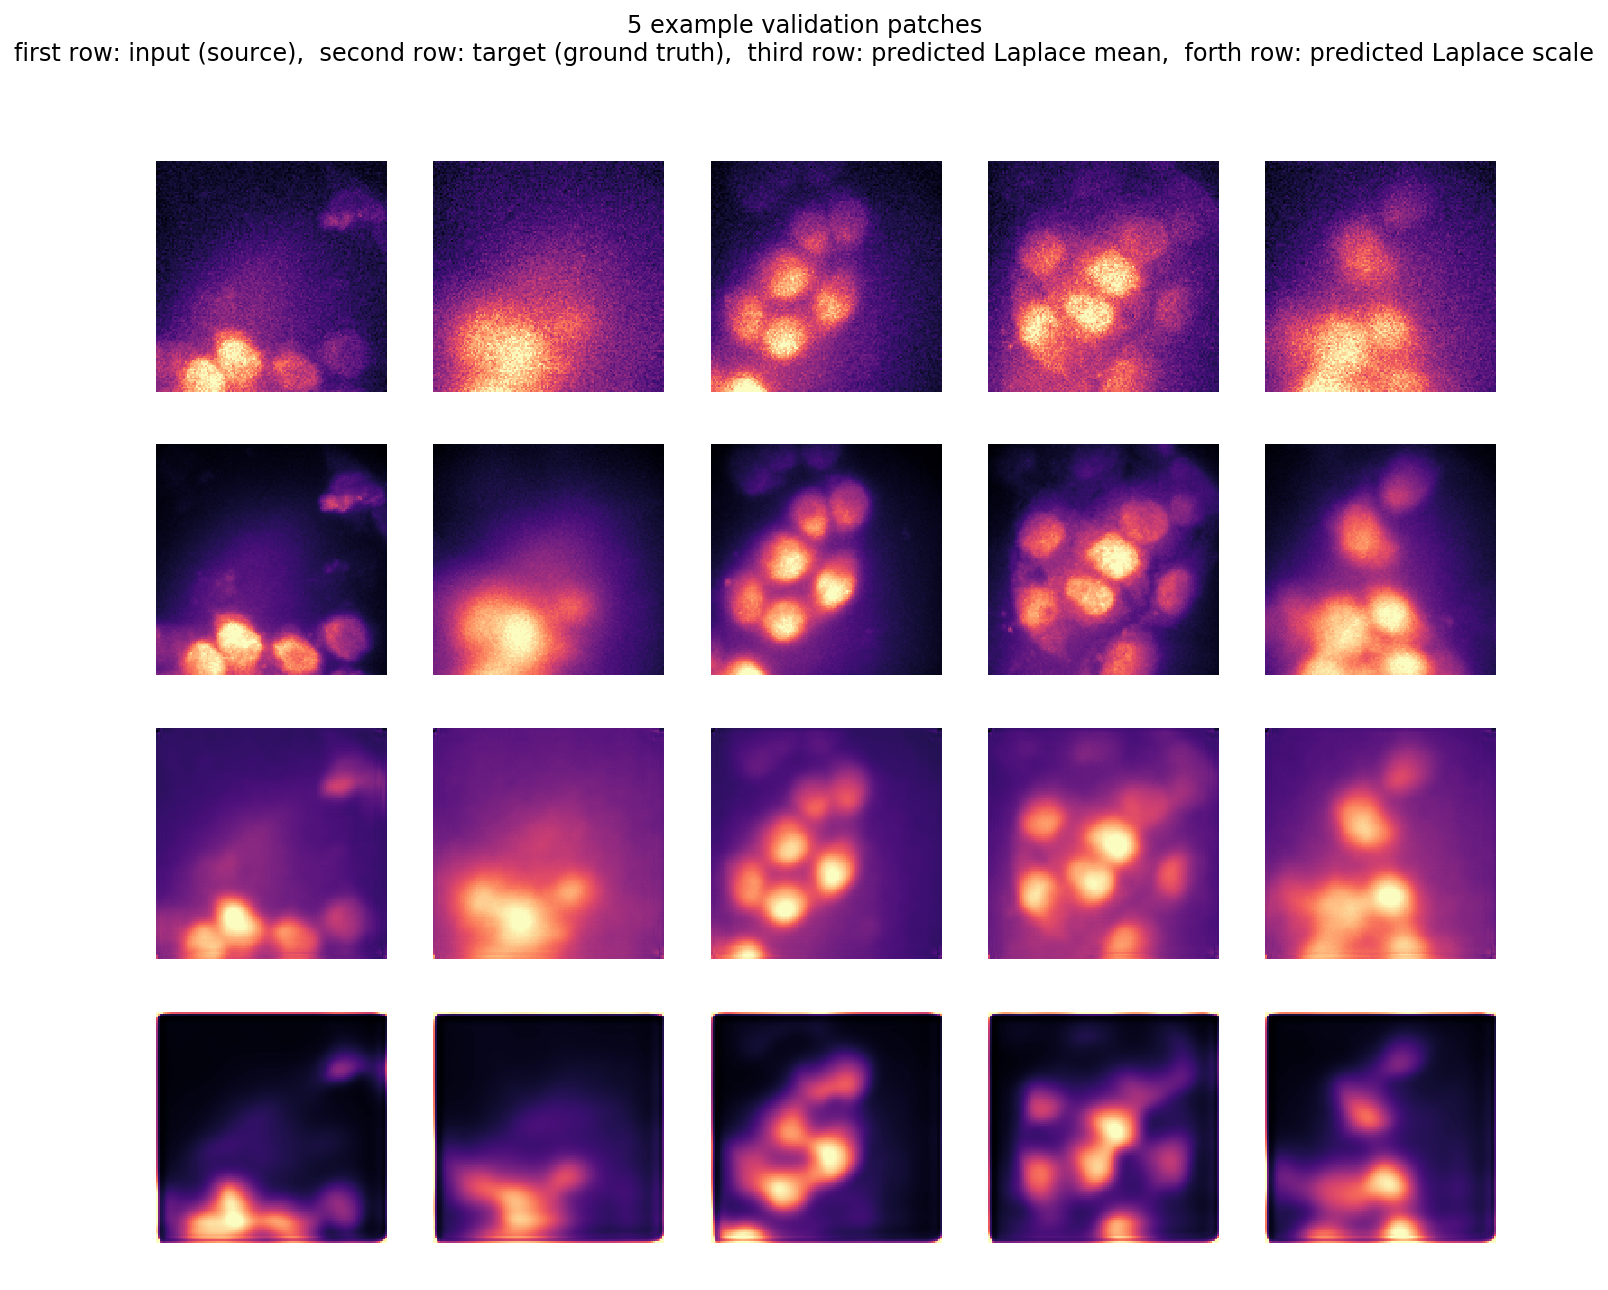

In [85]:
#CHANNEL 1
plt.figure(figsize=(12,10))
_P = hn_model_1.keras_model.predict(X_VAL_ALL_C[0][:5])
_P_mean  = _P[...,:(_P.shape[-1]//2)]
_P_scale = _P[...,(_P.shape[-1]//2):]
plot_some(X_VAL_ALL_C[0][:5],Y_VAL_ALL_C[0][:5],_P_mean,_P_scale,pmax=99.5)
plt.suptitle('5 example validation patches\n'      
             'first row: input (source),  '        
             'second row: target (ground truth),  '
             'third row: predicted Laplace mean,  '
             'forth row: predicted Laplace scale');

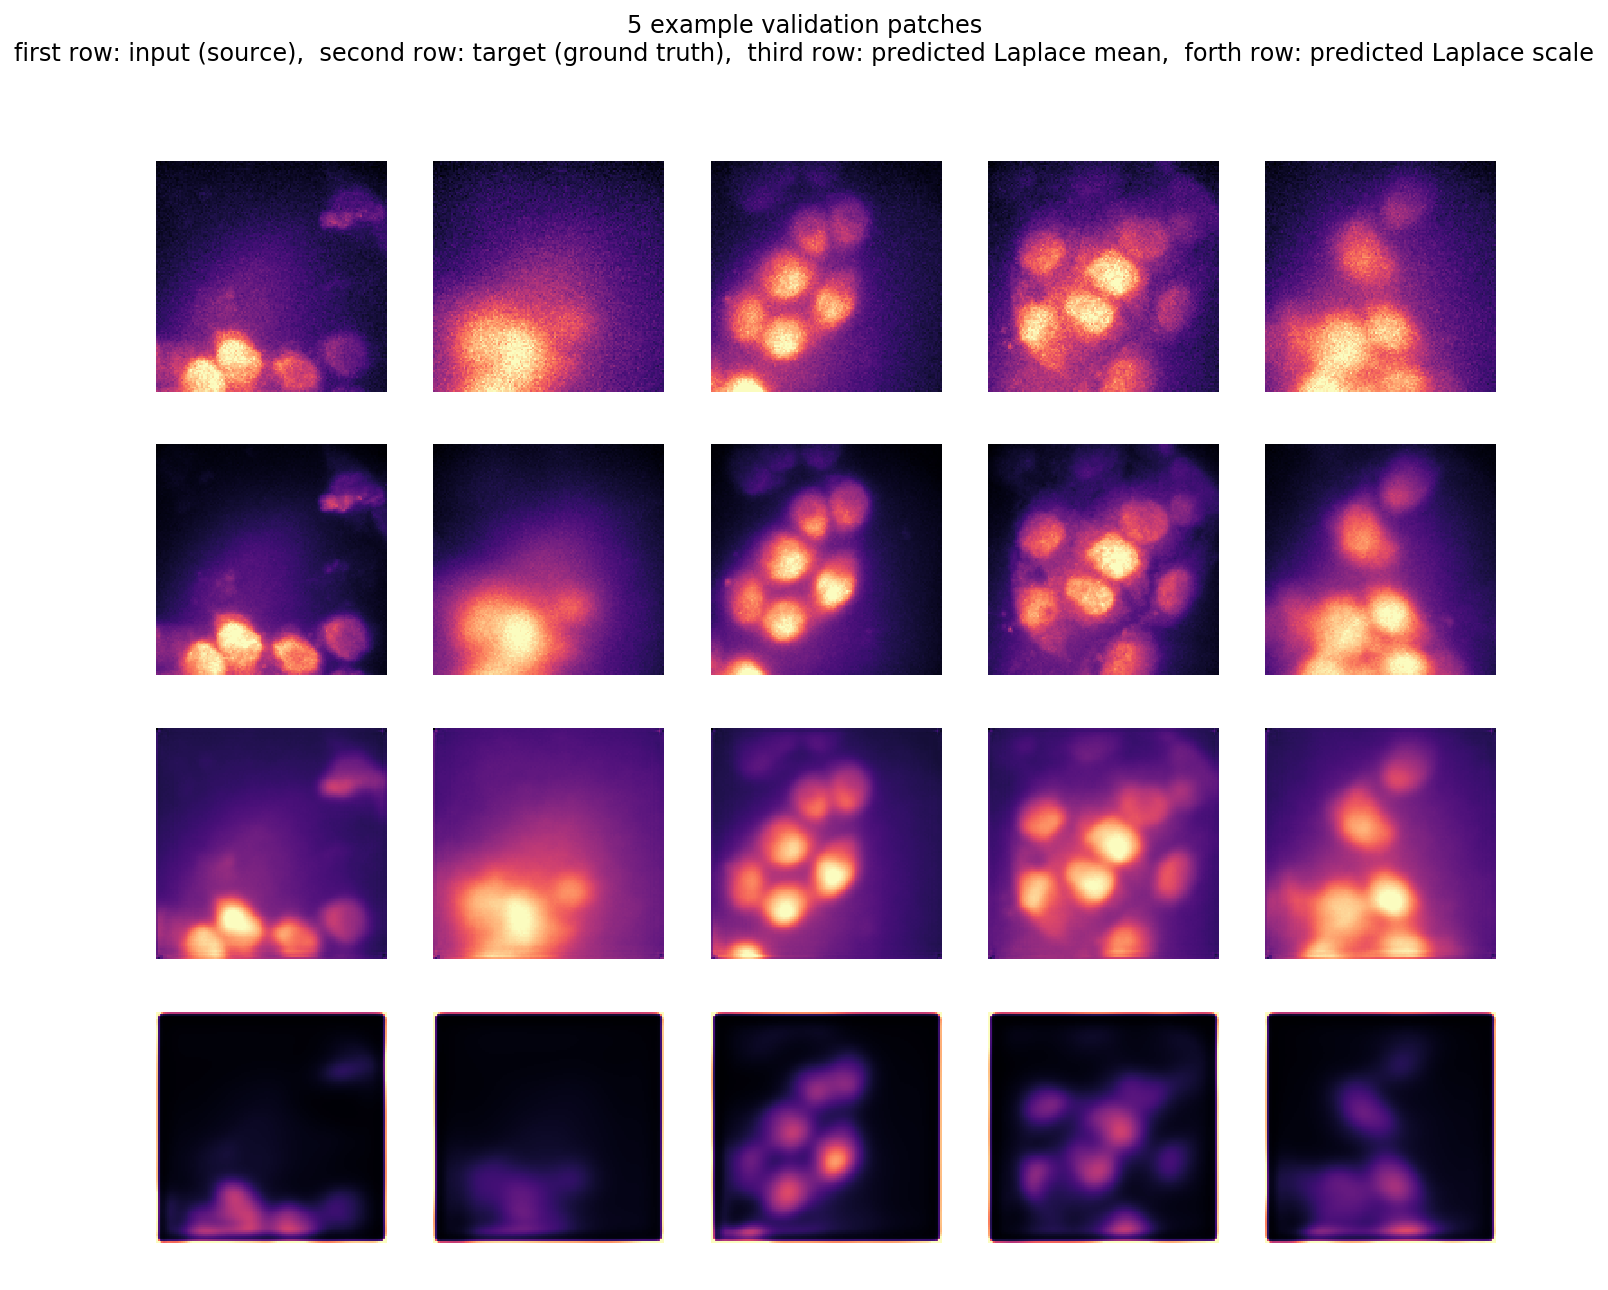

In [86]:
#CHANNEL 2
plt.figure(figsize=(12,10))
_P = hn_model_2.keras_model.predict(X_VAL_ALL_C[1][:5])
_P_mean  = _P[...,:(_P.shape[-1]//2)]
_P_scale = _P[...,(_P.shape[-1]//2):]
plot_some(X_VAL_ALL_C[1][:5],Y_VAL_ALL_C[1][:5],_P_mean,_P_scale,pmax=99.5)
plt.suptitle('5 example validation patches\n'      
             'first row: input (source),  '        
             'second row: target (ground truth),  '
             'third row: predicted Laplace mean,  '
             'forth row: predicted Laplace scale');

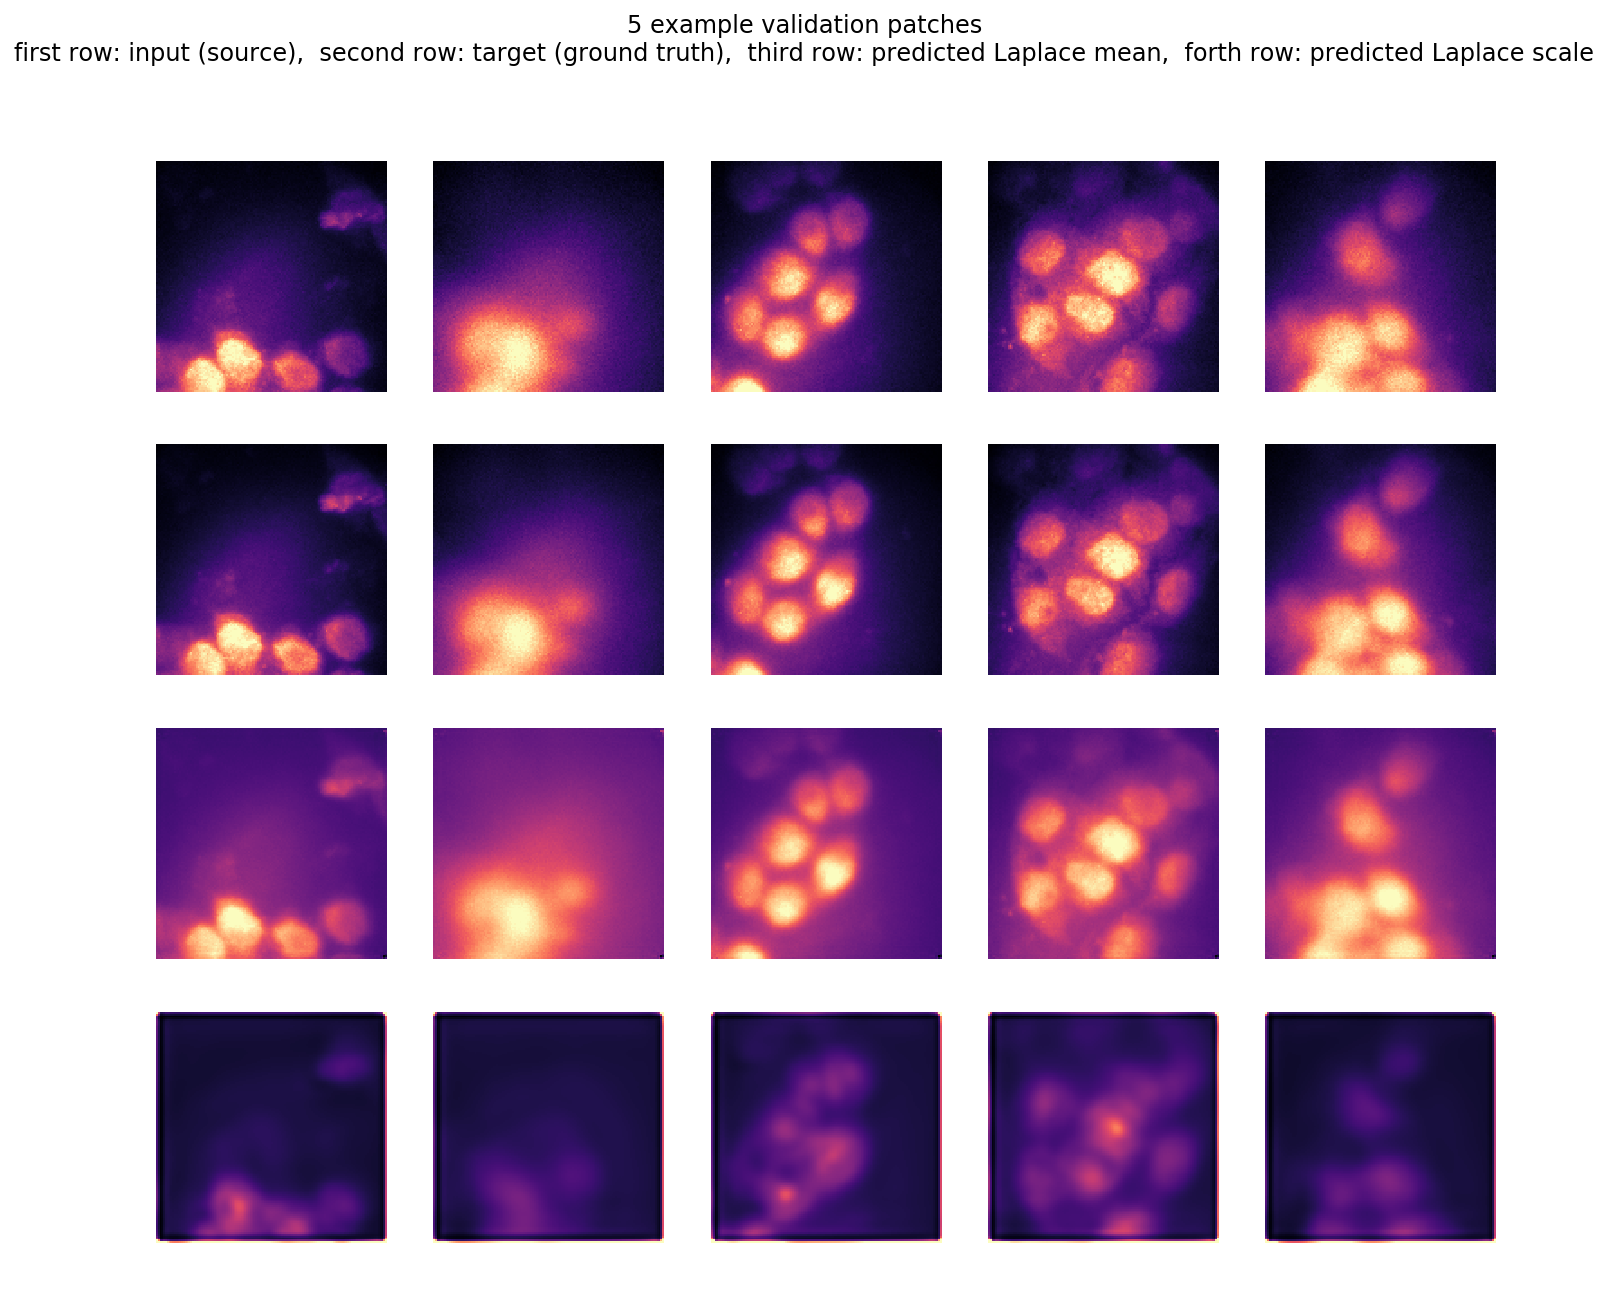

In [87]:
#CHANNEL 3
plt.figure(figsize=(12,10))
_P = hn_model_3.keras_model.predict(X_VAL_ALL_C[2][:5])
_P_mean  = _P[...,:(_P.shape[-1]//2)]
_P_scale = _P[...,(_P.shape[-1]//2):]
plot_some(X_VAL_ALL_C[2][:5],Y_VAL_ALL_C[2][:5],_P_mean,_P_scale,pmax=99.5)
plt.suptitle('5 example validation patches\n'      
             'first row: input (source),  '        
             'second row: target (ground truth),  '
             'third row: predicted Laplace mean,  '
             'forth row: predicted Laplace scale');

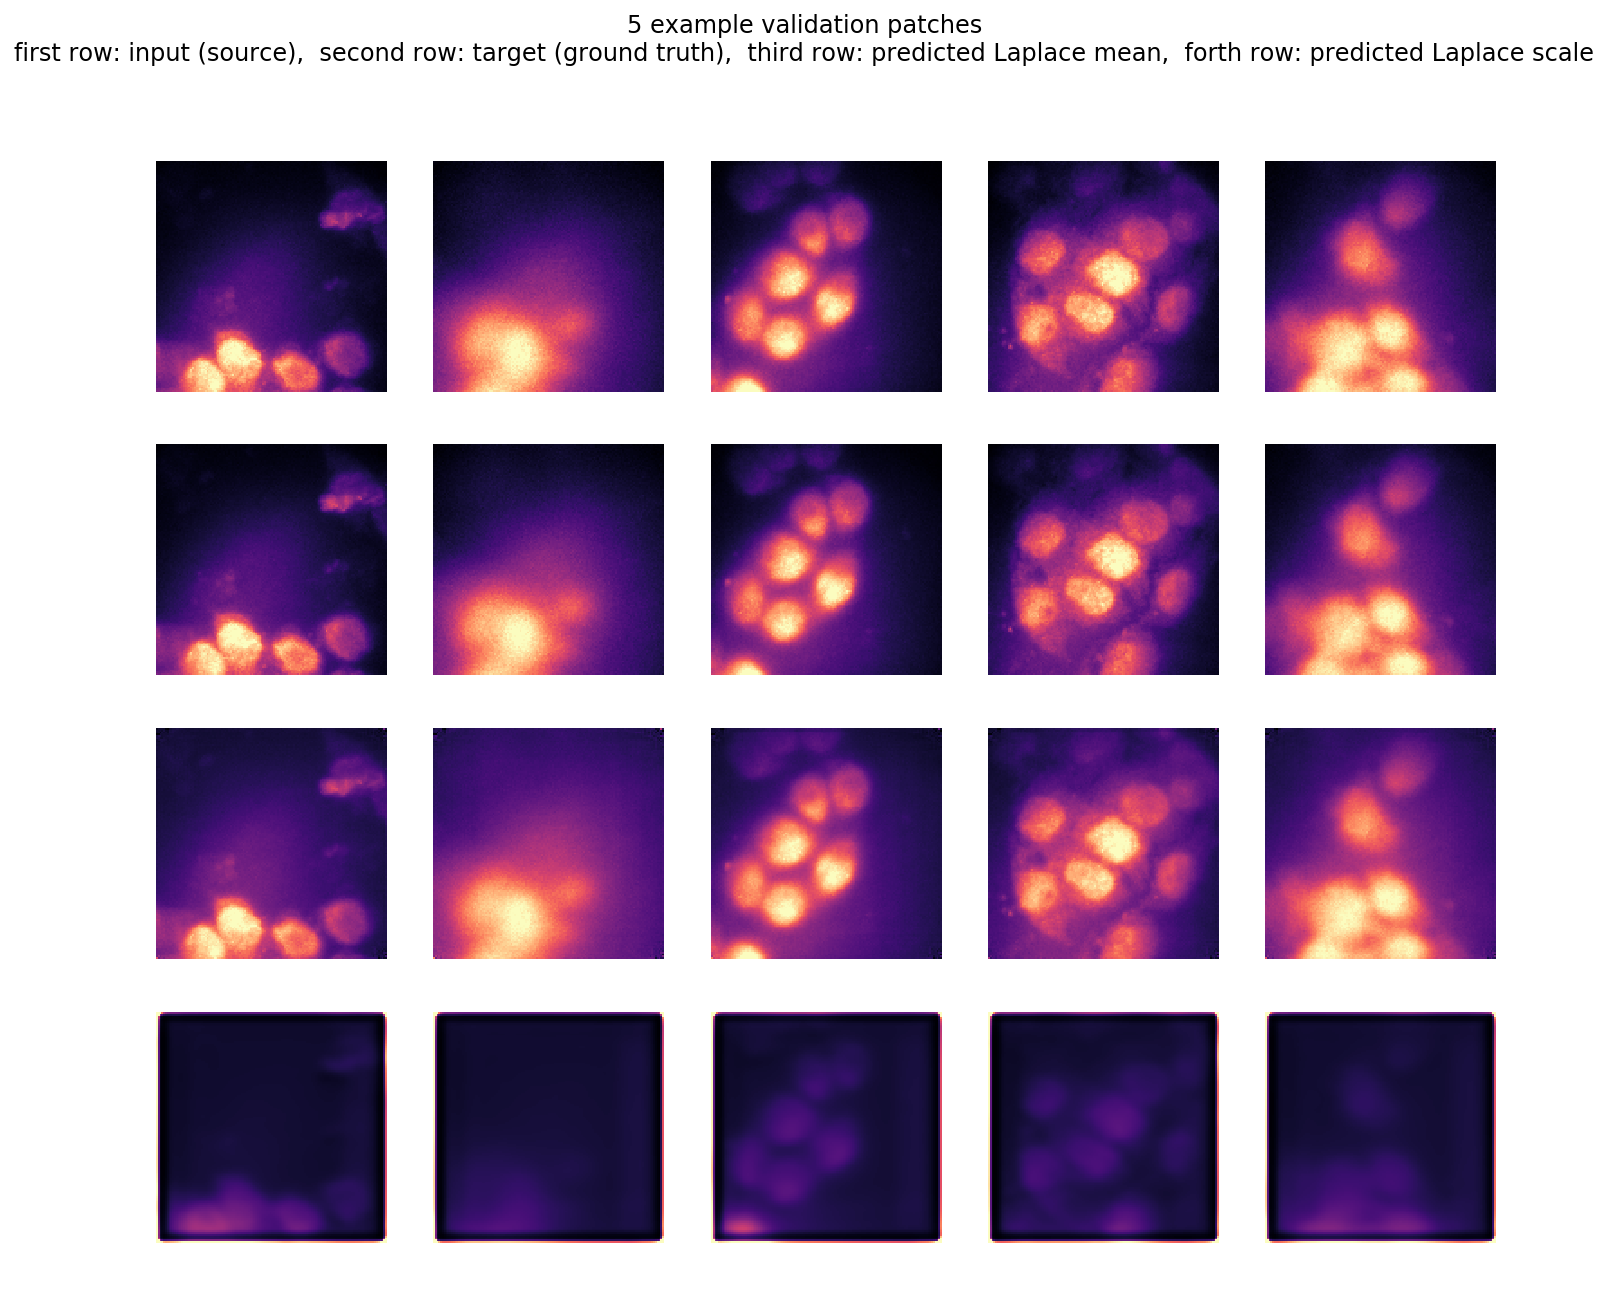

In [88]:
#CHANNEL 4
plt.figure(figsize=(12,10))
_P = hn_model_4.keras_model.predict(X_VAL_ALL_C[3][:5])
_P_mean  = _P[...,:(_P.shape[-1]//2)]
_P_scale = _P[...,(_P.shape[-1]//2):]
plot_some(X_VAL_ALL_C[3][:5],Y_VAL_ALL_C[3][:5],_P_mean,_P_scale,pmax=99.5)
plt.suptitle('5 example validation patches\n'      
             'first row: input (source),  '        
             'second row: target (ground truth),  '
             'third row: predicted Laplace mean,  '
             'forth row: predicted Laplace scale');

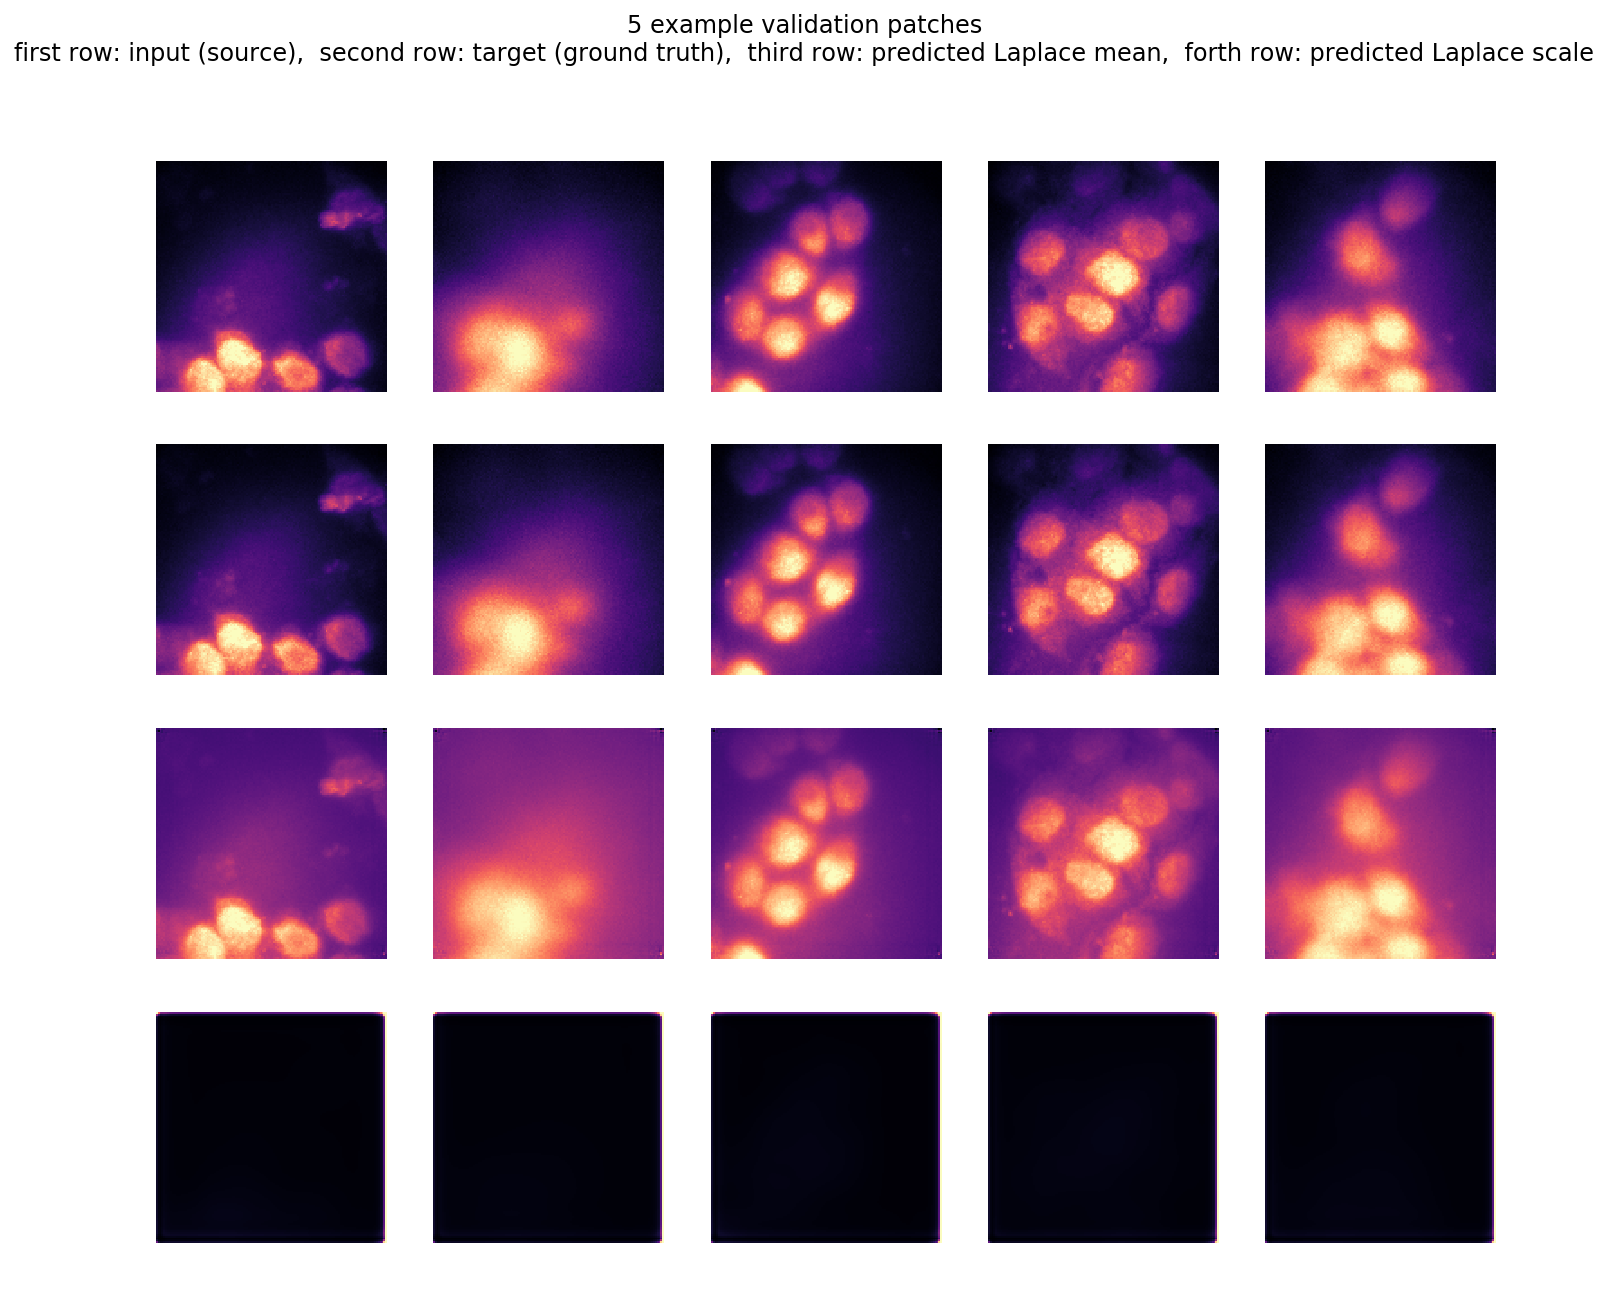

In [89]:
#CHANNEL 5
plt.figure(figsize=(12,10))
_P = hn_model_5.keras_model.predict(X_VAL_ALL_C[4][:5])
_P_mean  = _P[...,:(_P.shape[-1]//2)]
_P_scale = _P[...,(_P.shape[-1]//2):]
plot_some(X_VAL_ALL_C[4][:5],Y_VAL_ALL_C[4][:5],_P_mean,_P_scale,pmax=99.5)
plt.suptitle('5 example validation patches\n'      
             'first row: input (source),  '        
             'second row: target (ground truth),  '
             'third row: predicted Laplace mean,  '
             'forth row: predicted Laplace scale');

## Predictions


In [90]:
#image by image predictions -- predict for every image in data set
    
        
HN_MODEL_VAL_PREDS_1 = hn_model_1.keras_model.predict(X_VAL_ALL_C[0])
HN_MODEL_TEST_PREDS_1 = hn_model_1.keras_model.predict(X_TEST_ALL_C[0])

HN_MODEL_VAL_PREDS_2 = hn_model_2.keras_model.predict(X_VAL_ALL_C[1])
HN_MODEL_TEST_PREDS_2 = hn_model_2.keras_model.predict(X_TEST_ALL_C[1])

HN_MODEL_VAL_PREDS_3 = hn_model_3.keras_model.predict(X_VAL_ALL_C[2])
HN_MODEL_TEST_PREDS_3 = hn_model_3.keras_model.predict(X_TEST_ALL_C[2])

HN_MODEL_VAL_PREDS_4 = hn_model_4.keras_model.predict(X_VAL_ALL_C[3])
HN_MODEL_TEST_PREDS_4 = hn_model_4.keras_model.predict(X_TEST_ALL_C[3])

HN_MODEL_VAL_PREDS_5 = hn_model_5.keras_model.predict(X_VAL_ALL_C[4])
HN_MODEL_TEST_PREDS_5 = hn_model_5.keras_model.predict(X_TEST_ALL_C[4])


In [91]:
HN_MODEL_VAL_PREDS = [HN_MODEL_VAL_PREDS_1,
                     HN_MODEL_VAL_PREDS_2,
                     HN_MODEL_VAL_PREDS_3,
                     HN_MODEL_VAL_PREDS_4,
                     HN_MODEL_VAL_PREDS_5]

HN_MODEL_TEST_PREDS = [HN_MODEL_TEST_PREDS_1,
                      HN_MODEL_TEST_PREDS_2,
                      HN_MODEL_TEST_PREDS_3,
                      HN_MODEL_TEST_PREDS_4,
                      HN_MODEL_TEST_PREDS_5]

In [96]:
#For predictions -- 
# VAL_PRED[i,...,0] --> 0 is the mean Laplace, 
# VAL_PRED[i,...,1] --> 1 is the scaled Laplace

VAL_SSIM_ACTUALS_ALL_C = []
VAL_SSIM_PREDS_ALL_C = []

for c in range(0,5):
    VAL_SSIM_ACTUALS = []
    VAL_SSIM_PREDS = []
    for i in range(0,len(X_VAL_ALL_C[c])):
        #SSIM training to target
        ssim_actual = ssim(X_VAL_ALL_C[c][i,...,0], Y_VAL_ALL_C[c][i,...,0],
                       win_size=None,multichannel=True)
        VAL_SSIM_ACTUALS.append(ssim_actual)

        #SSIM prediction to target
        ssim_pred = ssim(HN_MODEL_VAL_PREDS[c][i,...,0], Y_VAL_ALL_C[c][i,...,0],
                     win_size=None,multichannel=True)
        VAL_SSIM_PREDS.append(ssim_pred)
      
    VAL_SSIM_ACTUALS_ALL_C.append(VAL_SSIM_ACTUALS)
    VAL_SSIM_PREDS_ALL_C.append(VAL_SSIM_PREDS)




In [97]:
VAL_SSIM_ACTUALS_ALL_C_means = []
VAL_SSIM_PREDS_ALL_C_means = []

for c in range(0,5):
    VAL_SSIM_ACTUALS_mean = np.array(VAL_SSIM_ACTUALS_ALL_C[c]).mean()
    VAL_SSIM_ACTUALS_ALL_C_means.append(VAL_SSIM_ACTUALS_mean)
    
    VAL_SSIM_PREDS_mean = np.array(VAL_SSIM_PREDS_ALL_C[c]).mean()
    VAL_SSIM_PREDS_ALL_C_means.append(VAL_SSIM_PREDS_mean)


In [99]:
for c in range(0,5):
    print("Validation SSIM Actuals Mean - Channel "+str(c)+": " + str(VAL_SSIM_ACTUALS_ALL_C_means[c]))
    print("Validation SSIM Predictions Mean - Channel "+str(c)+": " + str(VAL_SSIM_PREDS_ALL_C_means[c]))


Validation SSIM Actuals Mean - Channel 0: 0.46475270424964055
Validation SSIM Predictions Mean - Channel 0: 0.9931701771810258
Validation SSIM Actuals Mean - Channel 1: 0.5189030519562389
Validation SSIM Predictions Mean - Channel 1: 0.9958101752915319
Validation SSIM Actuals Mean - Channel 2: 0.8541206358248192
Validation SSIM Predictions Mean - Channel 2: 0.9978971153145679
Validation SSIM Actuals Mean - Channel 3: 0.9770964396387745
Validation SSIM Predictions Mean - Channel 3: 0.998157043736334
Validation SSIM Actuals Mean - Channel 4: 0.9971505267781074
Validation SSIM Predictions Mean - Channel 4: 0.9984989176853987


/gpfs/share/skynet/apps/anaconda3/envs/tensorflow-env/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


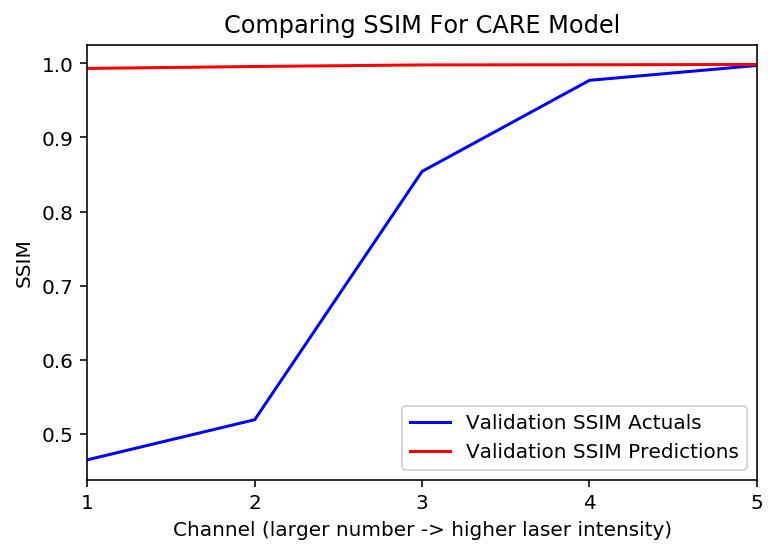

In [100]:

# Comparing MSE for denoising
plt.plot(list(range(1, 6)), VAL_SSIM_ACTUALS_ALL_C_means[0:5], 
         label="Validation SSIM Actuals", color='blue') 
plt.plot(list(range(1, 6)), VAL_SSIM_PREDS_ALL_C_means[0:5], 
         label="Validation SSIM Predictions", color='red') 


plt.title('Comparing SSIM For CARE Model')
plt.legend(loc = 'lower right')
# plt.ylim([0, 1])
plt.xlim([1, 5])
plt.axes().set_xticks(list(range(1, 6)), minor=False)

plt.ylabel('SSIM')
plt.xlabel('Channel (larger number -> higher laser intensity)')
plt.show()

In [26]:
#save images to folder

#Path('results_val').mkdir(exist_ok=True) --> if not already created, use this

for i in range(0,len(HN_MODEL_VAL_PREDS)):
    image = HN_MODEL_VAL_PREDS[i,...,0]
    save_tiff_imagej_compatible('results_val/%s_validation_image.tif' % str(hn_model.name)+str('_')+str(i), image, 'YX')

